# import

In [1]:
import numpy as np
import random
import pandas as pd
import scipy as sp
import scipy.stats
from scipy.stats import beta

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import math
import matplotlib as mpl
import matplotlib.font_manager as fm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from IPython.display import Latex

import gcsfs
from dfply import *
from IPython.core.display import display, HTML

import os
import sys
import pickle

# # 노트북 안에 그래프를 그리기 위해
# %matplotlib inline
# 노트북 폭
display(HTML("<style>.container { width:85% !important; }</style>"))
# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
# 한글 for mac
mpl.rc('font', family='AppleGothic')

# Thompson Sampling

## MAB - Thompson Sampling 개념

http://www.secmem.org/blog/2019/01/10/discounted-thompson-sampling/

http://sanghyukchun.github.io/96/

Bernoulli Bandit 문제에서 success가 발생하면 reward 1을 얻고 failure가 발생하면 아무 reward를 받지 않는다고 합시다. 

다시 말해, arm 
k
를 당기면 
θ
k
의 확률로 reward 1을 받고 
1
−
θ
k
의 확률로 reward를 받지 못 합니다. 

처음에 agent는 arm 
x
1
을 당기고 
r
1
의 reward를 받습니다. 

agent는 이 결과 
r
1
을 보고 arm 
x
2
를 당긴 뒤에 
r
2
의 reward를 얻게 됩니다. 

agent는 계속해서 이러한 과정을 반복할 것입니다. 

여기에서 agent가 사전에 각 
θ
k
에 대한 분포를 독립된 beta 분포로 추정했다고 합시다.

시각 
t
일 때, Thompson Sampling은 각 arm 
k
에 대해 추정값 
^
θ
k
을 posterior 분포인 
B
e
t
a
(
α
k
,
β
k
)
로부터 뽑습니다. 

이 중에서 가장 큰 추정값에 대한 arm 
x
t
를 수행하고 관찰된 reward 
r
t
에 따라 앞에서 설명한 바와 같이 해당 파래매터 
α
x
t
,
β
x
t
를 업데이트합니다.

파라매터가 (
α
,
β
)인 beta 분포는 평균이 
α/
(
α
+
β
)
이고 분산이 
α
β/
(
α
+
β
)
2
(
α
+
β
+
1
)
입니다. 

평균이 같을 때 
α
+
β
가 증가하면 분산이 작아지기 때문에 분포 모양이 평균을 중심으로 뾰족해지는 특성이 있습니다. 관찰한 reward가 많아질수록 arm에 대한 분포는 점점 뾰족해지는 양상을 띄며 각 arm에 대한 추정값이 점점 해당 분포의 평균에 가까운 경우가 많아집니다. 따라서 시간이 흐를수록 평균 reward가 낮은 arm은 선택될 가능성이 낮아지고 평균 reward가 높은 arm이 많이 선택됩니다.

## 1. Thompson Sampling Sample Code (Arm 갯수 상관없음)

### phase 1 - 데이터 생성

In [ ]:
########################################
######## phase 1 - 사전 데이터 집계 ########
########################################

#### 임의의 데이터 생성 - 실제 데이터는 bigquery GA테이블에서 추출 예정 ####
random.seed(1)
arm_1 = [random.randint(0,1) for x in range(3000)]
arm_2 = [random.randint(0,1) for x in range(2998)]
# arm_3 = [random.randint(0,1) for x in range(2987)]
# arm_4 = [random.randint(0,1) for x in range(3000)]

df = pd.DataFrame([arm_1, arm_2]).T.rename(columns={0:"arm_1", 1:"arm_2", 2:"arm_3", 3:"arm_4"})
df

,arm_1,arm_2
0,0.0,1.0
1,0.0,1.0
2,1.0,1.0
3,0.0,1.0
4,1.0,1.0
...,...,...
2995,1.0,1.0
2996,1.0,0.0
2997,0.0,0.0
2998,0.0,NaN


### phase 2 - 사전 데이터 집계 & Beta분포 추정 & Random Sampling

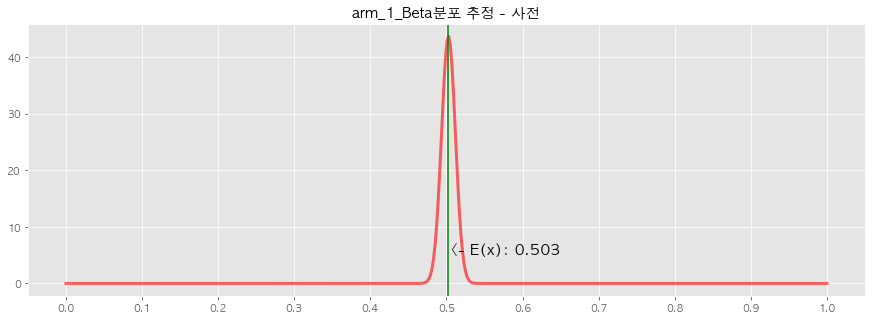

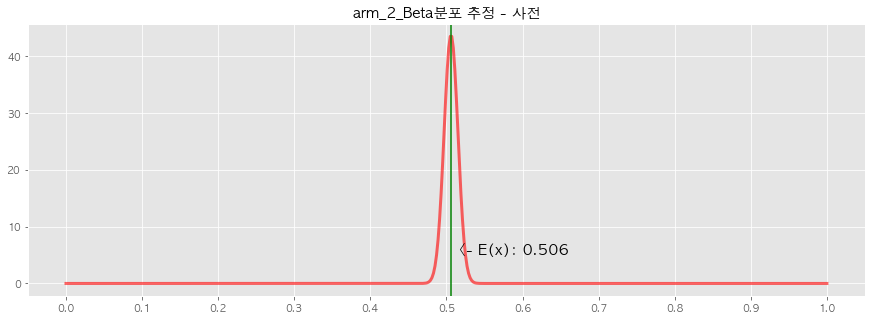

,arm_1,arm_2
0,0.519,0.505
1,0.486,0.511
2,0.515,0.503
3,0.509,0.517
4,0.505,0.517
...,...,...
2995,0.506,0.519
2996,0.519,0.511
2997,0.498,0.501
2998,0.510,0.518


In [ ]:
##########################################################
######## phase 2 - 사전 데이터 집계 & beta 분포 추정 & Random Sampling ########
##########################################################

#### 각 arm 집계, 샘플링에 필요한 dict, df 생성 ####
dict_click = {}
dict_len = {}
rvs_df = pd.DataFrame([0] * len(df))

#### 사전 데이터 집계 및 샘플링 #### 
# 수식상으로는 [1회 샘플링 -> argmax idx 노출 -> reward 여부 집계 -> 분포 업데이트] 인데,
# 현실적으로 수식처럼 운영하기가 어렵기 때문에 [n회 샘플링 -> arm별 argmax 횟수 집계 -> argmax 횟수 비율로 노출비율 조정 -> 익일 재노출 -> reward 여부 집계 -> 분포 업데이트 -> 반복] 의 과정으로 진행

for i in df.columns:
  dict_click[i] = df.loc[:,i].sum()
  dict_len[i] = len(df[df.loc[:,i] >= 0])
  x = np.linspace(0, 1, 500) # 0 ~ 1까지의 확률변수 공간 생성(간격 500)
  globals()["{}_total".format(i)] = dict_len[i]
  globals()["{}_click".format(i)] = dict_click[i]
  globals()["{}_non_click".format(i)] = dict_len[i] - dict_click[i]
  globals()["{}_rvs".format(i)] = []
## 사전확률 기준 beta분포 생성 - bernoulli 분포의 mean(=theta)를 기반으로 theta의 pdf를 추정한 beta 분포 생성 (bernoulli 분포의 theta = beta 분포의 mean) ##
  globals()["{}_pdf".format(i)] = beta.pdf(x, dict_click[i] + 1, dict_len[i] - dict_click[i] + 1)   #beta 분포 추정
  globals()["{}_mean".format(i)] = beta.stats(dict_click[i], dict_len[i] - dict_click[i], moments = 'mvsk')[0]   #beta 분포 기댓값 (mvsk = 평균, 분산, 왜도, 첨도 순)

#### beta 분포 추정 plot 영역 ####
  plt.figure(figsize = (15,5))
  plt.plot(x, globals()["{}_pdf".format(i)], 'r-', lw = 3, alpha = 0.6, label = str("{}_beta".format(i))) #사전정보가 없을 때 = beta(1, 1) -> 그래서 beta(a+1, b+1)
  plt.axvline(x = globals()["{}_mean".format(i)], c = 'g') # mean == [0]
  plt.text(x = np.round(globals()["{}_mean".format(i)], 2), y = 5, s = " <- E(x): " + str(np.round(globals()["{}_mean".format(i)], 3)), fontsize = 15)#, y = 10, s = "test")
#   plt.legend(loc = 'best', frameon = False)
  plt.xticks(ticks = (np.arange(0.0, 1.1, 0.1)))
  plt.title("{}_Beta분포 추정 - 사전".format(i))
  plt.show()
  
#### df길이 기준으로 random sampling ####
  for trial in range(len(df)):#trial range는 임의로 이렇게 한 것 - 최초 test data만큼 표본 추출
    globals()["{}_rvs".format(i)].append(beta.rvs(dict_click[i], dict_len[i] - dict_click[i], size = 1)[0]) #스칼라로 받아오려고 [0]
    
  globals()["{}_rvs_df".format(i)] = pd.DataFrame(globals()["{}_rvs".format(i)], columns = [str("{}".format(i))])
  rvs_df = rvs_df.merge(globals()["{}_rvs_df".format(i)], left_index = True, right_index = True, copy = False)

rvs_df = round(rvs_df.iloc[:,1:], 3)
rvs_df

### phase 3 - argmax winner 비율에 따른 노출비율 조정(target_update)

In [ ]:
#########################################################
######## phase 3 - argmax winner & target update ########
#########################################################
argmax_winner = []
# argmax_loser = []

#### rvs_df 에서 arm별로 몇 회 winning 했는지 집계 ####
for i in rvs_df.index:
  argmax_winner += [rvs_df.iloc[i,:].idxmax()]
#   argmax_loser += [rvs_df.iloc[i,:].idxmin()]

argmax_winner = pd.Series(argmax_winner).value_counts(normalize = True).sort_index(ascending = True)
argmax_winner = pd.DataFrame(argmax_winner).T

day_2_reco_target = 20000
argmax_winner = round(argmax_winner * day_2_reco_target, 0)

#### 조정비율 * target 건수가 실제 target을 초과하는 경우가 있음(round때문) -> 이를 방지하기 위한 처리 ####
for i in argmax_winner:
  if argmax_winner.loc[:, :i].values.sum() <= day_2_reco_target:
    pass
  else:
    argmax_winner.loc[:, i] -= abs(argmax_winner.loc[:, :i].values.sum() - day_2_reco_target)

argmax_winner

,arm_1,arm_2
0,8173.0,11827.0


### phase 4 - 조정하여 노출한 결과 집계 & beta 분포 update

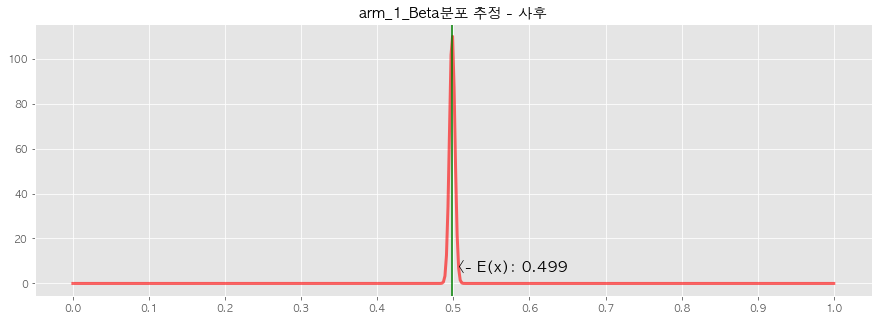

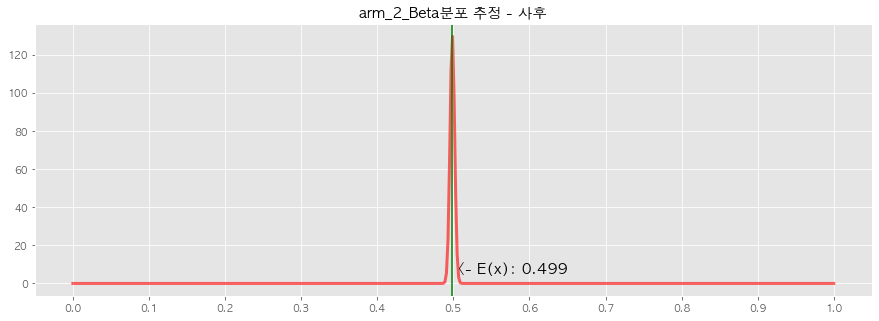

In [ ]:
#############################################################
######## phase 4 - 조정 노출한 결과 집계 & beta 분포 update #######
#############################################################

#### 조정 노출한 고객수 업데이트 - 실제 데이터는 bigquery GA테이블에서 추출 예정 ####
random.seed(1)
arm_1 = arm_1 + [random.randint(0,1) for x in range(int(argmax_winner["arm_1"]))]
arm_2 = arm_2 + [random.randint(0,1) for x in range(int(argmax_winner["arm_2"]))] 
# arm_3 = arm_3 + [random.randint(0,1) for x in range(int(argmax_winner["arm_3"]))]
# arm_4 = arm_4 + [random.randint(0,1) for x in range(int(argmax_winner["arm_4"]))]

df = pd.DataFrame([arm_1, arm_2]).T.rename(columns={0:"arm_1", 1:"arm_2", 2:"arm_3", 3:"arm_4"})

###############################################
######## phase 2 - beta 분포 내 sampling ########
###############################################

dict_click = {}
dict_len = {}
rvs_df = pd.DataFrame([0] * len(df))

for i in df.columns:
  dict_click[i] = df.loc[:,i].sum()
  dict_len[i] = len(df[df.loc[:,i] >= 0])
  globals()["{}_total".format(i)] = dict_len[i]
  globals()["{}_click".format(i)] = dict_click[i]
  globals()["{}_non_click".format(i)] = dict_len[i] - dict_click[i]
  globals()["{}_rvs".format(i)] = []
  globals()["{}_pdf".format(i)] = beta.pdf(x, dict_click[i] + 1, dict_len[i] - dict_click[i] + 1)
  globals()["{}_mean".format(i)] = beta.stats(dict_click[i], dict_len[i] - dict_click[i], moments = 'mvsk')[0]

#### plot 영역 ####
  x = np.linspace(0, 1, 500) # 0 ~ 1까지의 확률변수 공간 생성
  plt.figure(figsize = (15,5))
  plt.plot(x, globals()["{}_pdf".format(i)], 'r-', lw = 3, alpha = 0.6, label = str("{}_beta".format(i))) #사전정보가 없을 때 = beta(1, 1) -> 그래서 beta(a+1, b+1)
  plt.axvline(x = globals()["{}_mean".format(i)], c = 'g') # mean == [0]
  plt.text(x = np.round(globals()["{}_mean".format(i)], 2), y = 5, s = " <- E(x): " + str(np.round(globals()["{}_mean".format(i)], 3)), fontsize = 15)#, y = 10, s = "test")
#   plt.legend(loc = 'best', frameon = False)
  plt.title("{}_Beta분포 추정 - 사후".format(i))
  plt.xticks(ticks = (np.arange(0.0, 1.1, 0.1)))
  plt.show()
  
#   for trial in range(len(df)):#trial range는 임의로 이렇게 한 것
#     globals()["{}_rvs".format(i)].append(beta.rvs(dict_click[i], dict_len[i] - dict_click[i], size = 1)[0]) #스칼라로 받아오려고 [0]
    
#   globals()["{}_rvs_df".format(i)] = pd.DataFrame(globals()["{}_rvs".format(i)], columns = [str("{}".format(i))])
#   rvs_df = rvs_df.merge(globals()["{}_rvs_df".format(i)], left_index = True, right_index = True, copy = False)

# rvs_df = rvs_df.iloc[:,1:]
# rvs_df

## 2. Thompson Sampling Sample Code (하드코딩으로 짠 것(arm 2개만 가능)) 

### phase 0 - 사전 데이터가 없는 상태

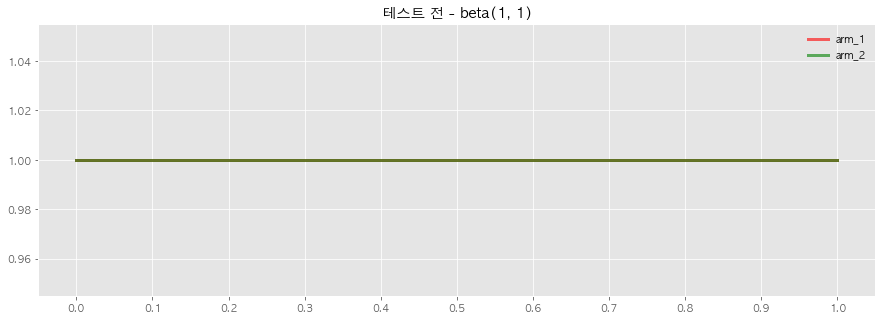

In [ ]:
########################################
######## phase 0 - 정보가 없는 상태 ########
########################################

x = np.linspace(0, 1, 500) # 0 ~ 1까지의 확률변수 공간 생성
plt.figure(figsize=(15,5))
plt.plot(x, beta.pdf(x, 1, 1), 'r-', lw=3, alpha=0.6, label='arm_1') #사전정보가 없을 때 = beta(1, 1) -> 그래서 beta(a+1, b+1)
# plt.axvline(x=np.round(beta.stats(arm_1_click, arm_1_non_click, moments='mvsk')[0],3), c = 'r') # mean == [0]
plt.plot(x, beta.pdf(x, 1, 1), 'g-', lw=3, alpha=0.6, label='arm_2')
# plt.axvline(x=np.round(beta.stats(arm_2_click, arm_2_non_click, moments='mvsk')[0],3), c = 'g')
plt.legend(loc='best', frameon=False)
# plt.tick_params(colors = "white")
plt.xticks(ticks = (np.arange(0.0, 1.1, 0.1)))
plt.title("테스트 전 - beta(1, 1)", {"color" : "black"})
plt.show()

### phase 1 - 사전(테스트 초기) 데이터 집계 & beta 분포 생성

day_1_arm_1_click: 1508
day_1_arm_1_non_click: 1492
day_1_arm_1_total: 3000
day_1_arm_1_mean: 0.503

day_1_arm_2_click: 1511
day_1_arm_2_non_click: 1477
day_1_arm_2_total: 2988
day_1_arm_2_mean: 0.506

day_1_arm_total: 5988




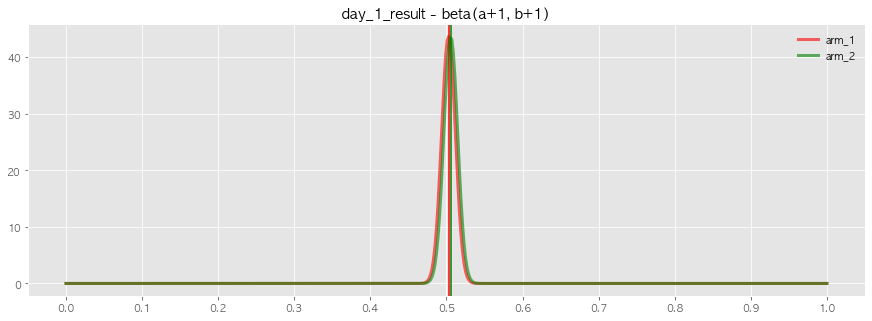

In [ ]:
########################################
######## phase 1 - 사전 데이터 집계 ########
########################################
# 임의의 데이터 생성
random.seed(1)
arm_1 = [random.randint(0,1) for x in range(3000)]
arm_2 = [random.randint(0,1) for x in range(2988)] # 두 리스트의 길이가 같다면 한 개의 data frame으로 처리해도 되는데, 그렇지 않을 것이기 때문에 

# print("arm_1:\n" + str(arm_1))
# print("arm_2:\n" + str(arm_2) + "\n" + "\n")

# 사전정보(확률) 데이터 집계
arm_1_click = sum(arm_1)
arm_1_non_click = len(arm_1) - arm_1_click
arm_2_click = sum(arm_2)
arm_2_non_click = len(arm_2) - arm_2_click

print("day_1_arm_1_click: " + str(arm_1_click))
print("day_1_arm_1_non_click: " + str(arm_1_non_click))
print("day_1_arm_1_total: " + str(arm_1_click + arm_1_non_click))
print("day_1_arm_1_mean: " + str(np.round(beta.stats(arm_1_click, arm_1_non_click, moments='mvsk')[0],3)) + "\n")

print("day_1_arm_2_click: " + str(arm_2_click))
print("day_1_arm_2_non_click: " + str(arm_2_non_click))
print("day_1_arm_2_total: " + str(arm_2_click + arm_2_non_click))
print("day_1_arm_2_mean: " + str(np.round(beta.stats(arm_2_click, arm_2_non_click, moments='mvsk')[0],3)) + "\n")
print("day_1_arm_total: " + str(arm_1_click + arm_1_non_click+arm_2_click + arm_2_non_click) + "\n" + "\n")


# 사전확률 기준 beta분포 생성 - bernoulli 분포의 mean prob(theta)를 기반으로 theta의 pdf를 추정한 beta 분포 생성 (bernoulli 분포의 theta = beta 분포의 mean)
x = np.linspace(0, 1, 500) # 0 ~ 1까지의 확률변수 공간 생성
plt.figure(figsize=(15,5))
plt.plot(x, beta.pdf(x, arm_1_click+1, arm_1_non_click+1), 'r-', lw=3, alpha=0.6, label='arm_1') #사전정보가 없을 때 = beta(1, 1) -> 그래서 beta(a+1, b+1)
plt.axvline(x=np.round(beta.stats(arm_1_click, arm_1_non_click, moments='mvsk')[0],3), c = 'r') # mean == [0]
plt.plot(x, beta.pdf(x, arm_2_click+1, arm_2_non_click+1), 'g-', lw=3, alpha=0.6, label='arm_2')
plt.axvline(x=np.round(beta.stats(arm_2_click, arm_2_non_click, moments='mvsk')[0],3), c = 'g')
plt.legend(loc='best', frameon=False)
# plt.tick_params(colors = "white")
plt.title("day_1_result - beta(a+1, b+1)", {"color" : "black"})
plt.xticks(ticks = (np.arange(0.0, 1.1, 0.1)))
plt.show()

### phase 2 - 생성한 분포 내에서 random sampling & argmax winner 집계

In [ ]:
####################################################
######## phase 2 - random sampling & argmax ########
####################################################
# argmax의 사전 단계 - 각 bandit별 beta 분포 내에서 랜덤 샘플링
# arm_1_rvs = []
# arm_2_rvs = []
# ####랜덤 샘플링 하더라도 한 쪽으로 치우치는 경향이 있으니 n회 avg로 조정하자!####
# for trial in range(len(arm_1)+len(arm_2)):#trial range는 임의로 이렇게 한 것
#   arm_1_rvs.append(beta.rvs(arm_1_click, arm_1_non_click, size=1)[0]) #스칼라로 받아오려고 [0]
#   arm_2_rvs.append(beta.rvs(arm_2_click, arm_2_non_click, size=1)[0])  
  
# prob_df = pd.DataFrame([arm_1_rvs, arm_2_rvs]).T.reset_index()
# prob_df.columns=["trial", "arm_1", "arm_2"]
# prob_df.trial += 1

arm_1_rvs = []
arm_2_rvs = []
rnd = []
####랜덤 샘플링 하더라도 한 쪽으로 치우치는 경향이 있으니 n회 avg로 조정하자!####
for e in range(5):
  for trial in range(len(arm_1)+len(arm_2)):#trial range는 임의로 이렇게 한 것
    arm_1_rvs.append(beta.rvs(arm_1_click, arm_1_non_click, size=1)[0]) #스칼라로 받아오려고 [0]
    arm_2_rvs.append(beta.rvs(arm_2_click, arm_2_non_click, size=1)[0])
    rnd.append(trial)
  
  prob_df = pd.DataFrame([arm_1_rvs, arm_2_rvs, rnd]).T
  prob_df.columns=["arm_1", "arm_2", "rnd"]
prob_df = prob_df.astype({"rnd":"int64"})
prob_df.groupby(by="rnd")[["arm_1","arm_2"]].mean().reset_index()


print("prob_df.head() & tail: \n" + str(prob_df.head()) + "\n" + str(prob_df.tail()) + "\n")



prob_df.head() & tail: 
      arm_1     arm_2  rnd
0  0.522172  0.502980    0
1  0.504367  0.497398    1
2  0.513129  0.512289    2
3  0.498619  0.504919    3
4  0.497795  0.496006    4
          arm_1     arm_2   rnd
29935  0.481279  0.523517  5983
29936  0.515414  0.497911  5984
29937  0.488960  0.519463  5985
29938  0.498841  0.503549  5986
29939  0.494859  0.513801  5987



### phase 3 - argmax winner 비율에 따른 노출비율 조정(target_update)

In [ ]:
#########################################################
######## phase 3 - argmax winner에 따른 노출비율 조정 ########
#########################################################
# argmax 단계 - 랜덤 샘플링한 값 중 argmax인 값의 집단을 더 많이 노출
argmax_winner = []
argmax_loser = []

for i in prob_df.index:
  if prob_df.arm_1[i] > prob_df.arm_2[i]:
    argmax_winner += ["arm_1"]
    argmax_loser += ["arm_2"]
  elif prob_df.arm_1[i] < prob_df.arm_2[i]:
    argmax_winner += ["arm_2"]
    argmax_loser += ["arm_1"]
  else:
    argmax_winner += ["draw"]
    argmax_loser += ["draw"]
    
arm_1_sum = arm_1_click + arm_1_non_click + argmax_winner.count("arm_1")
arm_2_sum = arm_2_click + arm_2_non_click + argmax_winner.count("arm_2")
arm_total = arm_1_sum + arm_2_sum

print("argmax_arm_1_sum: " + str(arm_1_sum))
print("argmax_arm_2_sum: " + str(arm_2_sum))
print("argmax_arm_total: " + str(arm_total) + "\n")

print("arm_1의 argmax_winner 반영: " + str(arm_1_sum / arm_total))
print("arm_2의 argmax_winner 반영: " + str(arm_2_sum / arm_total))
print("원래 수식상으로는 랜덤샘플링 & argmax winner 선정 후에 winner_arm기준 x_t(t시점에 1회 노출)를 수행하라고 되어있지만,\n" 
      "우리 컨텐츠 카드 특성상 노출을 아예 안할 수는 없고, 1회씩 하기에는 고객이 너무 많으니까 일단 집단별 비중을 조정하는 방식으로 활용" + "\n")
# day_1의 reward 획득률이 거의 차이가 없는데, 어떻게 samping & argmax 단계에서 비율이 이렇게 조정될 수 있을까...


argmax_arm_1_sum: 15089
argmax_arm_2_sum: 20839
argmax_arm_total: 35928

arm_1의 argmax_winner 반영: 0.419978846582053
arm_2의 argmax_winner 반영: 0.580021153417947
원래 수식상으로는 랜덤샘플링 & argmax winner 선정 후에 winner_arm기준 x_t(t시점에 1회 노출)를 수행하라고 되어있지만,
우리 컨텐츠 카드 특성상 노출을 아예 안할 수는 없고, 1회씩 하기에는 고객이 너무 많으니까 일단 집단별 비중을 조정하는 방식으로 활용



### phase 4 - 조정하여 노출한 결과 집계 & beta 분포 update

target_divide_arm_1: 2520
target_divide_arm_2: 3480
target_divide_total: 6000

day_2_arm_1_click: 1263
day_2_arm_1_non_click: 1257
day_2_arm_1_total: 2520

day_2_arm_2_click: 1763
day_2_arm_2_non_click: 1717
day_2_arm_2_total: 3480

day_2_arm_total: 6000


updated_arm_1_click: 2771
updated_arm_1_non_click: 2749
updated_arm_1_total: 5520
updated_arm_1_mean: 0.502

updated_arm_2_click: 3274
updated_arm_2_non_click: 3194
updated_arm_2_total: 6468

updated_arm_2_mean: 0.506

updated_arm_total: 11988




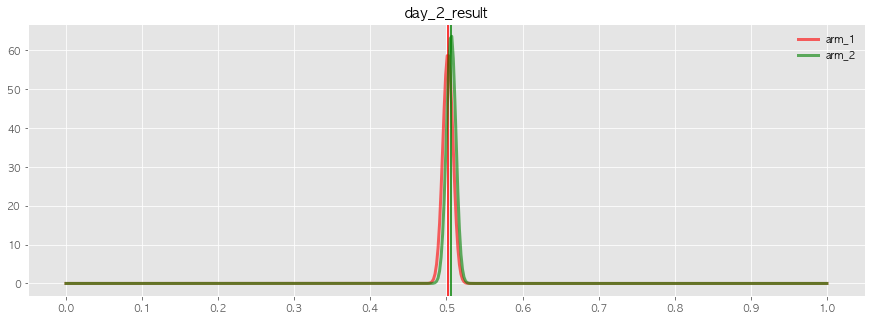

In [ ]:
#############################################################
######## phase 4 - 조정 노출한 결과 집계 & beta 분포 update #######
#############################################################
#bandit 노출비율 조정
target = 6000
random.seed(1)
arm_1 = [random.randint(0,1) for x in range(int(round(target*(arm_1_sum / arm_total), 0)))]
arm_2 = [random.randint(0,1) for x in range(target-int(round(target*(arm_1_sum / arm_total), 0)))]
print("target_divide_arm_1: " + str(len(arm_1)))
print("target_divide_arm_2: " + str(len(arm_2)))
print("target_divide_total: " + str(len(arm_1)+len(arm_2)) + "\n")

# beta분포 업데이트를 위한 데이터 집계
arm_1_click += sum(arm_1)
arm_1_non_click += len(arm_1) - sum(arm_1)
arm_2_click += sum(arm_2)
arm_2_non_click += len(arm_2) - sum(arm_2)
print("day_2_arm_1_click: " + str(sum(arm_1)))
print("day_2_arm_1_non_click: " + str(len(arm_1) - sum(arm_1)))
print("day_2_arm_1_total: " + str(len(arm_1)) + "\n")
print("day_2_arm_2_click: " + str(sum(arm_2)))
print("day_2_arm_2_non_click: " + str(len(arm_2) - sum(arm_2)))
print("day_2_arm_2_total: " + str(len(arm_2)) + "\n")
print("day_2_arm_total: " + str(len(arm_1) + len(arm_2)) + "\n" + "\n")


print("updated_arm_1_click: " + str(arm_1_click))
print("updated_arm_1_non_click: " + str(arm_1_non_click))
print("updated_arm_1_total: " + str(arm_1_click + arm_1_non_click))
print("updated_arm_1_mean: " + str(np.round(beta.stats(arm_1_click, arm_1_non_click, moments='mvsk')[0],3)) + "\n")

print("updated_arm_2_click: " + str(arm_2_click))
print("updated_arm_2_non_click: " + str(arm_2_non_click))
print("updated_arm_2_total: " + str(arm_2_click + arm_2_non_click) + "\n")
print("updated_arm_2_mean: " + str(np.round(beta.stats(arm_2_click, arm_2_non_click, moments='mvsk')[0],3)) + "\n")
print("updated_arm_total: " + str(arm_1_click + arm_1_non_click + arm_2_click + arm_2_non_click) + "\n" + "\n")

#beta분포 업데이트
x = np.linspace(0, 1, 500) # 0 ~ 1까지의 확률변수 공간 생성
plt.figure(figsize=(15,5))
plt.plot(x, beta.pdf(x, arm_1_click+1, arm_1_non_click+1), 'r-', lw=3, alpha=0.6, label='arm_1')
plt.axvline(x=np.round(beta.stats(arm_1_click, arm_1_non_click, moments='mvsk')[0],3), c = 'r')
plt.plot(x, beta.pdf(x, arm_2_click+1, arm_2_non_click+1), 'g-', lw=3, alpha=0.6, label='arm_2')
plt.axvline(x=np.round(beta.stats(arm_2_click, arm_2_non_click, moments='mvsk')[0],3), c = 'g')
plt.legend(loc='best', frameon=False)
# plt.tick_params(colors = "white")
plt.xticks(ticks = (np.arange(0.0, 1.1, 0.1)))
plt.title("day_2_result", {"color" : "black"})
plt.show()